## Convolutional Neural Network for Classifying Trends in Timeseries
Anthony van der Wal | UWA Data Analytics Bootcamp | Project 3

---

In [1]:
# dependencies
import ipywidgets as widgets
from datetime import datetime, date, timedelta
from tqdm import tqdm, trange
from pandas_datareader import data as pdr
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

---
### Date Range of Prediction

In [29]:
# period to predict - one month prior up to today
start_date = date.today() - timedelta(days=30)
end_date = date.today()

dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %d %b %Y '), date) for date in dates]
index = (0, len(options)-1)

# ipywidget slider to control date selection
selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

selection_range_slider

SelectionRangeSlider(description='Dates', index=(0, 30), layout=Layout(width='500px'), options=((' 25 Jan 2021…

In [30]:
# extract start/end dates from widget
start_date = selection_range_slider.value[0]
end_date = selection_range_slider.value[1]
print(start_date, end_date)

2021-02-15 00:00:00 2021-02-24 00:00:00


---
### Download EUR-USD Exchange

In [31]:
# data direct to dataframe
yf.pdr_override()
df = pdr.get_data_yahoo('EURUSD=X', start=start_date, end=end_date, interval='60m').tz_localize(None)
# df = pdr.get_data_yahoo('GOOG', start=start_date, end=end_date, interval='1d')
df.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-02-15 00:00:00,1.212415,1.212856,1.211974,1.212562,1.212562,0
2021-02-15 01:00:00,1.212562,1.213298,1.212121,1.213151,1.213151,0


---
### Derive Candlestick Components

In [32]:
# derive candlestick components from ohlc
#  upper-shadow, lower-shadow, real-body
with tqdm(total=df.shape[0]) as pbar:
    
    for index, row in df.iterrows():
        pbar.update(1)

        # real body - positive=rising / negative=falling
        df.loc[index,'real_body'] = df.loc[index,'Close'] - df.loc[index,'Open']

        # rising candle
        if df.loc[index,'Close'] >= df.loc[index,'Open']: 
            df.loc[index,'upper_shadow'] = df.loc[index,'High'] - df.loc[index,'Close']
            df.loc[index,'lower_shadow'] = df.loc[index,'Open'] - df.loc[index,'Low']

        # falling candle   
        else:
            df.loc[index,'upper_shadow'] = df.loc[index,'Open'] - df.loc[index,'High']
            df.loc[index,'lower_shadow'] = df.loc[index,'Low'] - df.loc[index,'Close']  
        
# tidy up
df = df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close'})
# df['date'] = df.index.strftime("%Y-%m-%d %H:%m")
df = df[['open', 'high', 'low', 'close', 'upper_shadow', 'lower_shadow', 'real_body']]
df.head(2)

100%|██████████| 159/159 [00:00<00:00, 929.13it/s]


,open,high,low,close,upper_shadow,lower_shadow,real_body
Datetime,,,,,,,
2021-02-15 00:00:00,1.212415,1.212856,1.211974,1.212562,0.000294,0.000441,0.000147
2021-02-15 01:00:00,1.212562,1.213298,1.212121,1.213151,0.000147,0.000441,0.000588


---
### Convert Features as 1D Timeseries to 2D Images

In [33]:
# gramian angular matrices (gam):
#  https://jfin-swufe.springeropen.com/articles/10.1186/s40854-020-00187-0
#  https://www.aaai.org/ocs/index.php/WS/AAAIW15/paper/viewFile/10179/10251 
#  https://github.com/pecu/Series2GAF/blob/master/cnn_example/series2gaf.py

# features
feature_list = ['open', 'close', 'real_body']

# image size => window_size(rows) x window_size(cols)
window_size = 10

# intialise the gam field
gramian_field = []

# number of data points
n = len(df['close'])

# loop through each feature
for this_feature in feature_list:

    # initialise the gam field for the feature
    gam_feature_set = []

    # loop through the data
    for i_data in trange(window_size, n+1, desc="Generating...", ascii=True):

        # select the data points to convert frm timeseries to gam (image)
        full_window_data =  list(df[this_feature][i_data-window_size : i_data])

        # scale the data
        rescaled_ts = np.zeros((window_size, window_size), float)
        min_ts = np.min(full_window_data)
        max_ts = np.max(full_window_data)
        diff = max_ts - min_ts
        if diff != 0:
            rescaled_ts = (full_window_data - min_ts) / diff

        # initialise the image
        this_gam = np.zeros((window_size, window_size), float)

        # calculate a component of the gam
        sin_ts = np.sqrt(np.clip(1 - rescaled_ts**2, 0, 1))

        # calculate the gam - summation method
        this_gam = np.outer(rescaled_ts, rescaled_ts) - np.outer(sin_ts, sin_ts)

        # add the gam to the feature set
        gam_feature_set.append(this_gam)

        # clear the gam ready for next
        del this_gam

    # ass the gam field of the feature set to the dataset
    gramian_field.append(gam_feature_set)

    # clear the gam field of the feature set
    del gam_feature_set

# finalise the gam field for each dataset
gam_pred = np.array(gramian_field)
gam_pred = np.moveaxis(gam_pred, 0, 3)
    
# summarise the results
print(f'| gam_pred: {gam_pred.shape} |')

Generating...: 100%|##########| 150/150 [00:00<00:00, 4741.29it/s]

| gam_pred: (150, 10, 10, 3) |


---
### Load the CNN Model
- Model has been trianed to classify 5 consecutive datapoints as either positive, negative, or neutral slope.
- Model architecture is typical for image classification with CNN.

In [34]:
# load the model
model = load_model('./analysis/eurusd_hour_real_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 16)          448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 32)          4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

---
### Predict the Categories in the Downloaded Data

In [35]:
# predicted codes
predicted_codes = model.predict_classes(gam_pred)

# labels - in same order as model was trained
labels = ['negative', 'neutral', 'positive']
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# review the count of predicted categories
predicted_labels = label_encoder.inverse_transform(predicted_codes)
(unique, counts) = np.unique(predicted_labels, return_counts=True)
np.asarray((unique, counts)).T

array([['negative', '39'],
       ['neutral', '69'],
       ['positive', '42']], dtype='<U21')

---
###  Add the Predicted Categories to the Dataframe

In [36]:
# insert predictions in dataframe

# initialise new column
df['prediction'] = ''

# find column location for use with iloc
pred_colno = df.columns.get_loc('prediction')

# loop through the dataframe
with tqdm(total=df.shape[0]) as pbar:    
    for index, (_, row) in enumerate(df.iterrows()):
        pbar.update(1)
        
        # first prediction starts after the first 'window_size' samples
        if index >= window_size-1:
            df.iloc[index, pred_colno] = predicted_labels[index-window_size+1]

100%|██████████| 159/159 [00:00<00:00, 3320.26it/s]


---
### Visualisation of the Predicted Categories

In [37]:
# visualise the results
#  overlay candlesticks with slope predictions

# candlesticks
fig = go.Figure(data=[go.Candlestick(
    x=df.loc[start_date : end_date].index,    
    open=df['open'].loc[start_date : end_date], 
    high=df['high'].loc[start_date : end_date], 
    low=df['low'].loc[start_date : end_date], 
    close=df['close'].loc[start_date : end_date],
)])

# find the rows ion df that correspond to positive or negative slopes
positive_indices = np.where(df['prediction'] == 'positive')
negative_indices = np.where(df['prediction'] == 'negative')
noprediction_indices = np.where(df['prediction'].iloc[:window_size])

# add vertical rectangles for positive slopes
for i in positive_indices[0]:
    fig.add_vrect(
        x0=df.iloc[i].name, x1=df.iloc[i-4].name,
        fillcolor="lightgreen", opacity=0.6,
        layer="below", line_width=0,
    )

# add vertical rectangles for negative slopes
for i in negative_indices[0]:
    fig.add_vrect(
        x0=df.iloc[i].name, x1=df.iloc[i-4].name,
        fillcolor="lightpink", opacity=0.6,
        layer="below", line_width=0,
    )
    
# add vertical rectangles for no prediction data points
for i in noprediction_indices[0]:
    fig.add_vrect(
        x0=df.iloc[i-4].name, x1=df.iloc[i-9].name,
        fillcolor="black", opacity=0.7,
        layer="below", line_width=0,
    )

# annotate and configure the plot
fig.update_layout(
    title='EURUSD',
    yaxis_title='price',
    xaxis_rangeslider_visible=True,
    autosize=True,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False)
)

# hide weekends
fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"])])

fig.show()

---
### Visualise the 1D Timeseries as 2D Images

In [38]:
# visualise a 1D (closing price and real-body) timeseries 
#  as 2D images (Gramian angular matrix)

# animate all the predicted gams
fig = px.imshow(
    gam_pred,
    animation_frame = 0,  
    facet_col = 3,
    facet_col_wrap = 3,
    color_continuous_scale='blues'
) 

# include the frame number and predicted category in the title
fig.update_layout(
    title=f'GAM - {window_size-1} - {df["prediction"][window_size-1]}',
    autosize=True,
)
for k in range(len(fig.frames)):
    fig.frames[k]['layout'].update(title_text=f'GAF - {k} - {df["prediction"][k+window_size-1]}')

# change the facet labels to reflect the feature being displayed
for a in range(len(fig.layout.annotations)):
    fig.layout.annotations[a].text = feature_list[a]

fig.show()

---
### BONUS - Uncertainty in Financial Price Data
- Visualising the randomness of price data
- Random Walk model characterised by real data
- Monte Carlo simulation of 1,000 random samples of future prices

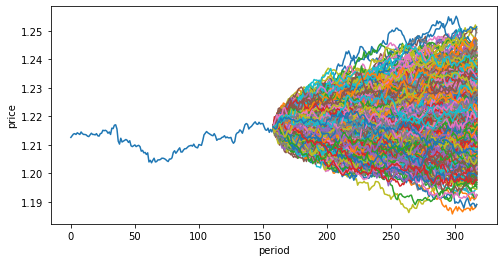

In [39]:
# monte carlo simulation of future prices

# seed value for the calculations
np.random.seed(42)

# number of periods to forecast
periods = df.shape[0]

# characterise the data - percentage change, mean, and sigma
df['daily_pc'] = df['close'].pct_change()
mu = df['daily_pc'].iloc[1:].mean()
sigma = df['daily_pc'].iloc[1:].std()

# simulate price - random walk
simulation = {}

# simulate from last real price data point
simulation['period'] = list(range(periods-1, periods+periods))

# create numerous simulated (forecast) timeseries
for i in range(1000):
    simulation['sim_'+str(i)] = [df['close'].iloc[-1]]
    for d in range(periods):
        simulation['sim_'+str(i)].append(
            simulation['sim_'+str(i)][-1]*
            np.exp((mu-(sigma**2/2))+sigma*np.random.normal())
        )

# new dataframe with real prices
real = {}
real['period'] = list(range(periods))
real['real'] = list(df['close'])
real = pd.DataFrame(real)

# simulation data frame with multiple price forecasts
simulation=pd.DataFrame(simulation)

# combine real and simulated dataframes
comb_df = real.merge(simulation, on='period', how='outer')
comb_df.drop(['period'], axis = 1, inplace = True)
comb_df.fillna(0.)

# plot combined dataframe
comb_df.plot(figsize=(8,4),grid=False,legend=False)
plt.xlabel('period')
plt.ylabel('price');

In [40]:
# histogram of end prices

# max and min of last simulated data
max_price = np.max(comb_df.iloc[-1,1:1000].max())
min_price = np.min(comb_df.iloc[-1,1:1000].min())
bins = np.linspace(min_price, max_price, 11)
bins_lst = [f'{i:.3f}-{j:.3f}' for i, j in zip(bins[:-1], bins[1:])]

# bins 
price_bins = pd.cut(comb_df.iloc[-1,1:1000], bins)

# metrics
price_pct = 100 * (comb_df.iloc[-1,1:1000].groupby(price_bins).count() / comb_df.iloc[-1,1:1000].count())
price_cnt = comb_df.iloc[-1,1:1000].groupby(price_bins).count()

# metrics -> dataframe
priceband_df = pd.DataFrame({'Price Band' : bins_lst,
                             'Percentage in band' : price_pct,
                             'Prices in band' : price_cnt})

# number format
format_dict = {'Percentage in band' : '{0:,.2f}%', 'Prices in band' : '{0:,}'}

# display
priceband_df.style.format(format_dict).hide_index()

Price Band,Percentage in band,Prices in band
1.189-1.195,0.80%,8
1.195-1.201,3.70%,37
1.201-1.208,7.91%,79
1.208-1.214,15.72%,157
1.214-1.220,20.12%,201
1.220-1.226,24.82%,248
1.226-1.233,13.01%,130
1.233-1.239,8.51%,85
1.239-1.245,4.20%,42
1.245-1.251,1.10%,11


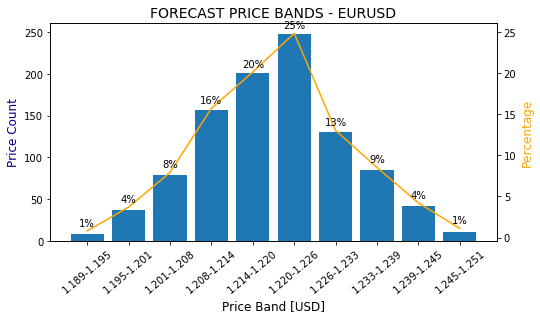

In [41]:
# data
x = priceband_df['Price Band']
y = priceband_df['Prices in band']
y2 = priceband_df['Percentage in band'].values

# plot
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x, y, width=0.8)
ax.set_title('FORECAST PRICE BANDS - EURUSD', fontsize=14)
ax.tick_params(axis='x', labelsize=10, rotation=40)
ax.set_xlabel('Price Band [USD]', fontsize=12)
ax.tick_params(axis='y', labelsize=10, rotation=0)
ax.set_ylabel('Price Count', fontsize=12, color='darkblue')
ax2 = ax.twinx()
ax2.plot(x, y2, color='orange')
ax2.tick_params(axis='y', labelsize=10, rotation=0)
ax2.set_ylabel('Percentage', fontsize=12, color='orange')
for x,y in zip(x,y2):
    label = "{:.0f}%".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,5), ha='center')